In [1]:
# try model with embedding data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from pathlib import Path
import warnings

In [2]:
# load all data
file_path = 'h_sapiens_abundance_PPI_seq_embeddings.parquet'
df = pd.read_parquet(file_path)

In [3]:
df_selected = df[df['sample_organ'].isin({'BRAIN',
 'CEREBRAL_CORTEX',
 'HEART',
 'LIVER',
 'LUNG',
 'PANCREAS',
 'PLASMA',
 'PLATELET',
 'SPLEEN',
 'WHOLE_ORGANISM'})]

In [4]:
df_selected = df_selected[df_selected['is_integrated'] == True]

In [17]:
# Prepare the data for regression
test_organ_abundance_human = df_selected[df_selected['sample_organ'] == 'LIVER']
train_organs_abundance_human = df_selected[(df_selected['sample_organ'] != 'LIVER')]

In [6]:
train_organs_abundance_human

,dataset_id,dataset_name,dataset_description,organism_id,organism_name,sample_organ,is_integrated,quality_score,coverage,publication_link,...,ProteinName,GeneSymbol,Sequence,uniprot_status,nog_id,abundance,EnsemblTranscript,EnsemblGene,PPI_embeddings,sequence_embeddings
56182,3692721588,H.sapiens - Lung (Integrated),integrated dataset: weighted average of all H....,9606,H.sapiens,LUNG,True,30.3,67.0,N/A,...,Albumin,"['ALB', 'GIG20', 'GIG42', 'PRO0903', 'PRO1708'...",MKWVTFISLLFLFSSAYSRGVFRRDAHKSEVAHRFKDLGEENFKAL...,available,NOG009613,27123.000,ENST00000295897,ENSG00000163631,"[0.01572, 0.00785, 0.010025, -0.01097, -0.0174...","[-0.06354, 0.0074, 0.08466, 0.02298, -0.01147,..."
56183,3692721588,H.sapiens - Lung (Integrated),integrated dataset: weighted average of all H....,9606,H.sapiens,LUNG,True,30.3,67.0,N/A,...,None,['HBA1'],None,None,NOG039241,15420.000,ENST00000320868,ENSG00000206172,"[0.146, -0.04395, -0.00908, 0.03014, -0.02135,...","[0.06995, 0.01424, -0.000669, -0.03812, -0.030..."
56184,3692721588,H.sapiens - Lung (Integrated),integrated dataset: weighted average of all H....,9606,H.sapiens,LUNG,True,30.3,67.0,N/A,...,Hemoglobin subunit alpha (Alpha-globin) (Hemog...,"['HBA1;', 'HBA2']",MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPH...,available,NOG039241,14856.000,ENST00000251595,ENSG00000188536,"[0.1547, -0.02129, -0.01663, 0.02698, -0.02042...","[0.06995, 0.01424, -0.000669, -0.03812, -0.030..."
56185,3692721588,H.sapiens - Lung (Integrated),integrated dataset: weighted average of all H....,9606,H.sapiens,LUNG,True,30.3,67.0,N/A,...,"Fatty acid-binding protein, liver (Fatty acid-...","['FABP1', 'FABPL']",MSFSGKYQLQSQENFEAFMKAIGLPEELIQKGKDIKGVSEIVQNGK...,available,NOG009902,7512.000,ENST00000295834,ENSG00000163586,"[0.00449, 0.05606, 0.04944, 0.002422, -0.01275...","[0.01868, -0.0119, 0.00871, -0.02475, 0.003374..."
56186,3692721588,H.sapiens - Lung (Integrated),integrated dataset: weighted average of all H....,9606,H.sapiens,LUNG,True,30.3,67.0,N/A,...,Vimentin,['VIM'],MSTRSVSSSSYRRMFGGPGTASRPSSSRSYVTTSTRTYSLGSALRP...,available,NOG009158,5633.000,ENST00000544301,ENSG00000026025,"[0.041, -0.0222, 0.04755, -0.0373, -0.003492, ...","[-0.0336, 0.0272, -0.02344, -0.01247, 0.02335,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537093,4290589278,H.sapiens - Cerebral cortex (Integrated),integrated dataset: weighted average of all H....,9606,H.sapiens,CEREBRAL_CORTEX,True,27.7,60.0,N/A,...,Probable E3 ubiquitin-protein ligase MARCHF10 ...,"['MARCHF10', 'MARCH10', 'RNF190']",MLHDARDRQKFFSDVQYLRDMQHKVDSEYQACLRRQEYRRDPNEKK...,available,NOG031048,0.014,ENST00000583600,ENSG00000173838,"[-0.01678, 0.0817, 0.036, 0.0003529, 0.02655, ...","[0.001326, -0.04422, -0.0074, -0.00086, -0.004..."
1537094,4290589278,H.sapiens - Cerebral cortex (Integrated),integrated dataset: weighted average of all H....,9606,H.sapiens,CEREBRAL_CORTEX,True,27.7,60.0,N/A,...,Pleckstrin homology-like domain family B member 3,['PHLDB3'],MGTRSSPEEGTPPPLVPECDVEVQPQGHPEESREQEASEVLAEPSS...,available,NOG009476,0.013,ENST00000292140,ENSG00000176531,"[0.02023, -0.05698, 0.001915, -0.00793, -0.005...","[-0.02107, -0.01714, 0.02367, -0.0282, -0.0243..."
1537095,4290589278,H.sapiens - Cerebral cortex (Integrated),integrated dataset: weighted average of all H....,9606,H.sapiens,CEREBRAL_CORTEX,True,27.7,60.0,N/A,...,Zinc finger MYM-type protein 6 (Transposon-der...,"['ZMYM6', 'Buster2', 'KIAA1353', 'ZNF258']",MKEPLDGECGKAVVPQQELLDKIKEEPDNAQEYGCVQQPKTQESKL...,available,NOG008919,0.013,ENST00000357182,ENSG00000163867,"[0.01541, -0.02754, -0.01037, 0.0035, -0.01964...","[-0.01126, 0.02388, 0.02231, 0.01682, -0.00503..."
1537096,4290589278,H.sapiens - Cerebral cortex (Integrated),integrated dataset: weighted average of all H....,9606,H.sapiens,CEREBRAL_CORTEX,True,27.7,60.0,N/A,...,Pecanex-like protein 2 (Pecanex homolog protei...,"['PCNX2', 'KIAA0435', 'PCNXL2']",MVSQVLQLLRQGVWAALTGGWYHDPEQSKFTNSCHLYLWLFLLLLP...,available,N

In [18]:
test_organ_abundance_human = test_organ_abundance_human[['sample_organ', 'abundance', 'UniprotAccession', 'PPI_embeddings', 'sequence_embeddings']]
train_organs_abundance_human = train_organs_abundance_human[['sample_organ', 'abundance', 'UniprotAccession', 'PPI_embeddings', 'sequence_embeddings']]

# only keep rows with nog_id in kidney_abundance
test_organ_abundance_human = test_organ_abundance_human[test_organ_abundance_human['UniprotAccession'].notna()]
test_organ_abundance_human = test_organ_abundance_human[test_organ_abundance_human['abundance'].notna()]
proteins_kidney = test_organ_abundance_human['UniprotAccession'].unique()

# only keep rows with nog_id in other_abundance
train_organs_abundance_human = train_organs_abundance_human[train_organs_abundance_human['UniprotAccession'].isin(proteins_kidney)]

test_organ_abundance_human = test_organ_abundance_human[test_organ_abundance_human['UniprotAccession'].isin(train_organs_abundance_human['UniprotAccession'])]

# remove duplicates in kidney_abundance_mouse
test_organ_abundance_human = test_organ_abundance_human.drop_duplicates(subset=['UniprotAccession'])

# remove duplicates in other_abundance_mouse per organ
train_organs_abundance_human = train_organs_abundance_human.drop_duplicates(subset=['UniprotAccession', 'sample_organ'])

In [19]:
# split the PPI and sequence embeddings into separate columns by splitting the vector 
def split_embeddings(df, column_name):
    embeddings = df[column_name]
    # Find the embedding length (skip NaN)
    first_valid = embeddings[embeddings.apply(lambda x: isinstance(x, (list, np.ndarray)))].iloc[0]
    embedding_length = len(first_valid)

    # Replace NaN with zeros
    embeddings_filled = embeddings.apply(
        lambda x: x if isinstance(x, (list, np.ndarray)) else [0.0] * embedding_length
    )

    split_df = pd.DataFrame(embeddings.tolist(), columns=[f'{column_name}_{i}' for i in range(embeddings.iloc[0].shape[0])])
    return pd.concat([df.reset_index(drop=True), split_df], axis=1)
train_organs_abundance_human = split_embeddings(train_organs_abundance_human, 'PPI_embeddings')
train_organs_abundance_human = split_embeddings(train_organs_abundance_human, 'sequence_embeddings')

In [20]:
test_expression = test_organ_abundance_human[['sample_organ', 'abundance', 'UniprotAccession']]
train_expression = train_organs_abundance_human[['sample_organ', 'abundance', 'UniprotAccession']]

# log transform the abundance values
test_expression['abundance'] = np.log1p(test_expression['abundance'])
train_expression['abundance'] = np.log1p(train_expression['abundance'])

train_expression_wide = train_expression.pivot(index='UniprotAccession', columns='sample_organ', values='abundance').reset_index()

# recombine the PPI and sequence embeddings with the expression data
# To avoid duplicate rows, drop duplicates by 'UniprotAccession' before merging
train_organs_abundance_human_unique = train_organs_abundance_human.drop_duplicates(subset=['UniprotAccession'])
train_organs_abundance_human_ready = pd.merge(
    train_expression_wide,
    train_organs_abundance_human_unique.drop(columns=['sample_organ', 'abundance', 'PPI_embeddings', 'sequence_embeddings']),
    left_on='UniprotAccession',
    right_on='UniprotAccession',
    how='left'
)

C:\Users\ellen\AppData\Local\Temp\ipykernel_9528\37929950.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_expression['abundance'] = np.log1p(test_expression['abundance'])
C:\Users\ellen\AppData\Local\Temp\ipykernel_9528\37929950.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_expression['abundance'] = np.log1p(train_expression['abundance'])


In [50]:
X = train_organs_abundance_human_ready.fillna(0).set_index('UniprotAccession')
y = test_expression.set_index('UniprotAccession')['abundance']
X = X.loc[y.index]

In [22]:
X

c:\Users\ellen\anaconda3\envs\myenv\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
c:\Users\ellen\anaconda3\envs\myenv\Lib\site-packages\pandas\io\formats\format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,BRAIN,CEREBRAL_CORTEX,HEART,LUNG,PANCREAS,PLASMA,PLATELET,SPLEEN,WHOLE_ORGANISM,PPI_embeddings_0,...,sequence_embeddings_1014,sequence_embeddings_1015,sequence_embeddings_1016,sequence_embeddings_1017,sequence_embeddings_1018,sequence_embeddings_1019,sequence_embeddings_1020,sequence_embeddings_1021,sequence_embeddings_1022,sequence_embeddings_1023
UniprotAccession,,,,,,,,,,,,,,,,,,,,,
P69905,9.674829,9.804551,9.235716,9.606226,9.199886,8.534837,8.734077,9.356603,8.434029,0.154663,...,-0.115845,0.033081,0.046967,-0.102539,0.026031,-0.003132,-0.049622,0.056427,-0.051727,0.078552
P07148,3.642836,2.797281,3.594569,8.924390,5.351858,4.295924,0.000000,3.569533,5.789960,0.004490,...,-0.045074,0.032257,-0.028961,-0.048950,0.023041,-0.061676,-0.024704,-0.096924,0.052368,0.012100
P62328,8.889033,10.206735,8.132119,8.497806,9.735483,9.713356,7.984803,10.398824,10.786511,0.022751,...,-0.081421,0.056427,-0.082092,0.005512,0.062805,-0.102844,0.003963,0.101685,0.078186,0.058258
P02768,9.129564,9.681593,9.298992,10.208174,9.674515,11.303574,8.397734,9.300912,9.637893,0.015717,...,-0.150757,-0.026489,0.064575,0.029678,0.027298,-0.014877,-0.041016,0.046326,0.058136,0.050293
P00325,2.442347,2.130610,6.378426,8.090709,7.096721,3.117950,0.000000,7.424762,5.837730,0.000355,...,-0.048553,-0.030289,-0.019043,-0.067993,0.064026,-0.017853,-0.051208,-0.019958,0.034943,-0.014542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q16538,0.003992,0.819780,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000900,0.012131,...,0.004936,-0.033661,-0.016632,-0.008690,0.003077,0.044586,0.008881,0.016418,0.006653,0.036835
Q9NRU3,0.379121,1.922788,0.311154,0.118672,0.378436,0.000000,0.000000,0.000000,0.045929,-0.005676,...,-0.007835,-0.028229,0.006329,-0.002161,0.025681,-0.017960,0.014557,0.000077,0.021545,0.059540
O15360,0.001000,0.000000,0.000300,0.090754,0.000000,0.000000,0.000000,1.205971,0.242946,0.005527,...,-0.008469,-0.037689,0.003355,0.042816,-0.014297,0.027588,-0.003624,0.004940,0.002064,0.027603


In [51]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.preprocessing import PolynomialFeatures

# Only use the first 9 columns of X for interaction terms
X_interact = X.iloc[:, :9]
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_interact_poly = poly.fit_transform(X_interact)

# Concatenate the interaction features with the rest of X (excluding the original 9 columns to avoid duplication)
X_full = np.concatenate([X_interact_poly, X.iloc[:, 9:].values], axis=1)

# Split into train/test using the same indices as before
# Use pandas .loc to select by index label
X_full_df = pd.DataFrame(X_full, index=X.index)
X_train_full = X_full_df.loc[X_train.index]
X_test_full = X_full_df.loc[X_test.index]

# Train model
model = LinearRegression()
model.fit(X_train_full, y_train)

# get other evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score
y_pred = model.predict(X_test_full)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.3f}")
print(f"R^2 Score: {r2:.3f}")

# Coefficients
coefficients = model.coef_
intercept = model.intercept_

# Generate feature names for the polynomial features
poly_feature_names = poly.get_feature_names_out(X_interact.columns)
other_feature_names = X.columns[9:]
all_feature_names = list(poly_feature_names) + list(other_feature_names)

coefficients_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})
coefficients_df['Absolute_Coefficient'] = coefficients_df['Coefficient'].abs()
coefficients_df = coefficients_df.sort_values(by='Absolute_Coefficient', ascending=False)
coefficients_df


Mean Squared Error: 35559.328
R^2 Score: -10405.281


,Feature,Coefficient,Absolute_Coefficient
442,PPI_embeddings_397,7012.736363,7012.736363
413,PPI_embeddings_368,-5554.332967,5554.332967
220,PPI_embeddings_175,-4425.894366,4425.894366
502,PPI_embeddings_457,4373.207265,4373.207265
536,PPI_embeddings_491,-4372.774726,4372.774726
...,...,...,...
22,CEREBRAL_CORTEX SPLEEN,-0.001448,0.001448
1254,sequence_embeddings_697,-0.001343,0.001343
5,PLASMA,0.001325,0.001325
12,BRAIN PANCREAS,0.000515,0.000515


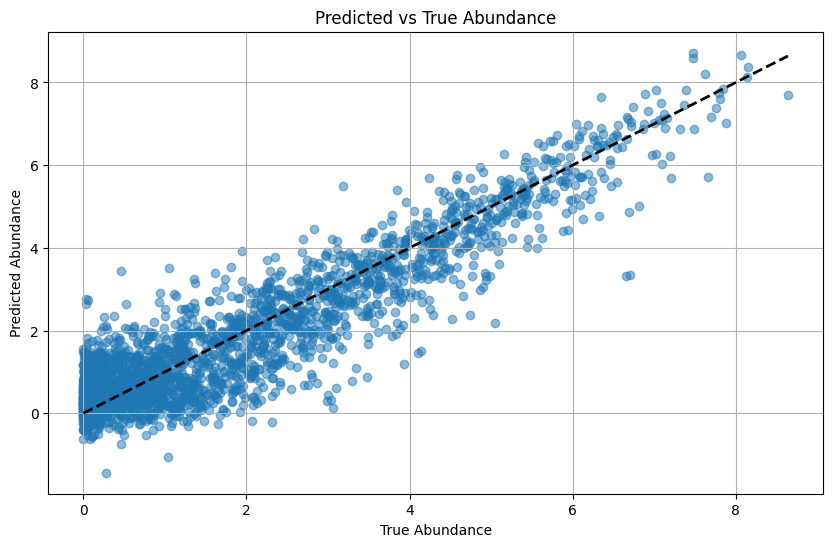

In [24]:
# plot y_pred vs y_test
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Abundance')
plt.ylabel('Predicted Abundance')
plt.title('Predicted vs True Abundance')
plt.grid()
plt.show()

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr

X = train_organs_abundance_human_ready.fillna(0).set_index('UniprotAccession')
y = test_expression.set_index('UniprotAccession')['abundance']
X = X.loc[y.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model without interaction terms
model = XGBRegressor(tree_method='hist', n_jobs=-1, random_state=42,n_estimators=300,
    learning_rate=0.1,
    max_depth=5, reg_alpha=0.5, reg_lambda=2)
model.fit(X, y)

# Predict and evaluate
y_pred = np.expm1(model.predict(X_test))
y_test_nonlog = np.expm1(y_test)
mse = mean_squared_error(y_test_nonlog, y_pred)
r2 = r2_score(y_test_nonlog, y_pred)
spearman_corr, _ = spearmanr(y_test_nonlog, y_pred)
print(f"Mean Squared Error: {mse:.3f}")
print(f"R^2 Score: {r2:.3f}")
print(f"Spearman Correlation: {spearman_corr:.3f}")

# Feature importances
importances = model.feature_importances_
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
feature_importances_df


Mean Squared Error: 5379.247
R^2 Score: 0.972
Spearman Correlation: 0.960


,Feature,Importance
3,LUNG,0.185436
4,PANCREAS,0.021130
46,PPI_embeddings_37,0.012907
2,HEART,0.011401
345,PPI_embeddings_336,0.009774
...,...,...
927,sequence_embeddings_406,0.000000
525,sequence_embeddings_4,0.000000
1112,sequence_embeddings_591,0.000000
936,sequence_embeddings_415,0.000000


In [33]:
# load all data
file_path = 'm_musculus_abundance_PPI_seq_embeddings.parquet'
df_mouse = pd.read_parquet(file_path)

In [34]:
df_mouse_selected = df_mouse[df_mouse['sample_organ'].isin({'BRAIN',
 'CEREBRAL_CORTEX',
 'HEART',
 'LIVER',
 'LUNG',
 'PANCREAS',
 'PLASMA',
 'PLATELET',
 'SPLEEN',
 'WHOLE_ORGANISM'})]

In [35]:
df_mouse_selected = df_mouse_selected[df_mouse_selected['is_integrated'] == True]

In [36]:
# Prepare the data for regression
test_organ_abundance_mouse = df_mouse_selected[df_mouse_selected['sample_organ'] == 'LIVER']
train_organs_abundance_mouse = df_mouse_selected[(df_mouse_selected['sample_organ'] != 'LIVER')]

In [37]:
train_organs_abundance_mouse

,dataset_id,dataset_name,dataset_description,organism_id,organism_name,sample_organ,is_integrated,quality_score,coverage,publication_link,...,ProteinName,GeneSymbol,Sequence,uniprot_status,nog_id,abundance,EnsemblTranscript,EnsemblGene,PPI_embeddings,sequence_embeddings
14989,961549256,M.musculus - Brain (Integrated),integrated dataset: weighted average of all M....,10090,M.musculus,BRAIN,True,38.1,51.0,N/A,...,Thymosin beta-4 (T beta 4) [Cleaved into: Hemo...,"['Tmsb4x', 'Ptmb4', 'Tmsb4']",MLLPATMSDKPDMAEIEKFDKSKLKKTETQEKNPLPSKETIEQEKQ...,available,NOG039385,13489.000,ENSMUST00000112172,ENSMUSG00000049775,"[0.03653, -0.06256, 0.01936, -0.01581, -0.0863...","[-0.01492, 0.02368, 0.1863, -0.05252, 0.03848,..."
14990,961549256,M.musculus - Brain (Integrated),integrated dataset: weighted average of all M....,10090,M.musculus,BRAIN,True,38.1,51.0,N/A,...,Tubulin alpha-4A chain (EC 3.6.5.-) (Alpha-tub...,"['Tuba4a', 'Tuba4']",MRECISVHVGQAGVQMGNACWELYCLEHGIQPDGQMPSDKTIGGGD...,available,NOG047599,12358.000,ENSMUST00000186213,ENSMUSG00000026202,"[0.004646, -0.01044, -0.04892, 0.01374, 0.0046...","[0.0881, 0.1666, -0.01161, -0.01953, 0.0451, 0..."
14991,961549256,M.musculus - Brain (Integrated),integrated dataset: weighted average of all M....,10090,M.musculus,BRAIN,True,38.1,51.0,N/A,...,Heat shock cognate 71 kDa protein (EC 3.6.4.10...,"['Hspa8', 'Hsc70', 'Hsc73']",MSKGPAVGIDLGTTYSCVGVFQHGKVEIIANDQGNRTTPSYVAFTD...,available,NOG047319,12056.000,ENSMUST00000015800,ENSMUSG00000015656,"[0.013, -0.02377, 0.008095, 0.01292, -0.02042,...","[0.10455, 0.11536, -0.0452, 0.0359, 0.07294, -..."
14992,961549256,M.musculus - Brain (Integrated),integrated dataset: weighted average of all M....,10090,M.musculus,BRAIN,True,38.1,51.0,N/A,...,Large ribosomal subunit protein eL39 (60S ribo...,['Rpl39'],MSSHKTFRIKRFLAKKQKQNRPIPQWIRMKTGNKIRYNSKRRHWRR...,available,NOG045965,8977.000,ENSMUST00000115231,ENSMUSG00000079641,"[-0.0241, -0.001349, 0.01576, 0.02205, 0.0244,...","[0.05234, 0.1608, 0.06433, 0.02975, 0.02275, 0..."
14993,961549256,M.musculus - Brain (Integrated),integrated dataset: weighted average of all M....,10090,M.musculus,BRAIN,True,38.1,51.0,N/A,...,Hemoglobin subunit beta-1 (Beta-1-globin) (Hem...,"['Hbb-b1', 'Hbb-bs']",MVHLTDAEKAAVSCLWGKVNSDEVGGEALGRLLVVYPWTQRYFDSF...,available,NOG037124,8668.000,ENSMUST00000023934,ENSMUSG00000052305,"[0.04837, 0.03348, -0.02173, 0.01358, 0.0844, ...","[0.0951, 0.0465, 0.02182, -0.02905, -0.01616, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399581,2778588166,M.musculus - Pancreas (Integrated),integrated dataset: weighted average of all M....,10090,M.musculus,PANCREAS,True,20.9,29.0,N/A,...,Cyclin-dependent kinase 7 (EC 2.7.11.22) (EC 2...,"['Cdk7', 'Cak', 'Cdkn7', 'Crk4', 'Mo15', 'Mpk-7']",MAVDVKSRAKRYEKLDFLGEGQFATVYKARDKNTNQIVAIKKIKLG...,available,NOG045509,0.003,ENSMUST00000091299,ENSMUSG00000069089,"[0.02563, -0.01955, -0.009094, -0.03348, -0.05...","[0.02985, 0.0843, -0.00911, 0.0357, -0.02968, ..."
399582,2778588166,M.musculus - Pancreas (Integrated),integrated dataset: weighted average of all M....,10090,M.musculus,PANCREAS,True,20.9,29.0,N/A,...,Thioredoxin domain-containing protein 15,['Txndc15'],MQLLCWWQVLLWVLGLPAHGLEVAEDSGHPWREERPVPALQVGAVY...,available,NOG005442,0.003,ENSMUST00000021959,ENSMUSG00000021497,"[-0.01484, 0.006557, -0.0421, 0.02371, -0.0117...","[0.01938, 0.00949, 0.05603, 0.03677, -0.04105,..."
399583,2778588166,M.musculus - Pancreas (Integrated),integrated dataset: weighted average of all M....,10090,M.musculus,PANCREAS,True,20.9,29.0,N/A,...,Kinesin-like protein KIF7,['Kif7'],MGLEAQRLPGAEEAPVRVALRVRPLLPKELLHGHQSCLRVEPERGR...,available,NOG040634,0.003,ENSMUST00000183846,ENSMUSG00000050382,"[0.003, -0.05807, -0.03075, 0.03363, 0.04736, ...","[-0.01139, -0.01461, 0.002104, -0.01073, -0.00..."
399584,2778588166,M.musculus - Pancreas (Integrated),integrated dataset: weighted average of all M....,10090,M.musculus,PANCREAS,True,20.9,29.0,N/A

In [38]:
test_organ_abundance_mouse = test_organ_abundance_mouse[['sample_organ', 'abundance', 'UniprotAccession', 'PPI_embeddings', 'sequence_embeddings']]
train_organs_abundance_mouse = train_organs_abundance_mouse[['sample_organ', 'abundance', 'UniprotAccession', 'PPI_embeddings', 'sequence_embeddings']]

# only keep rows with nog_id in liver_abundance
test_organ_abundance_mouse = test_organ_abundance_mouse[test_organ_abundance_mouse['UniprotAccession'].notna()]
test_organ_abundance_mouse = test_organ_abundance_mouse[test_organ_abundance_mouse['abundance'].notna()]
proteins_liver = test_organ_abundance_mouse['UniprotAccession'].unique()

# only keep rows with nog_id in other_abundance
train_organs_abundance_mouse = train_organs_abundance_mouse[train_organs_abundance_mouse['UniprotAccession'].isin(proteins_liver)]

test_organ_abundance_mouse = test_organ_abundance_mouse[test_organ_abundance_mouse['UniprotAccession'].isin(train_organs_abundance_mouse['UniprotAccession'])]

# remove duplicates in liver_abundance_mouse
test_organ_abundance_mouse = test_organ_abundance_mouse.drop_duplicates(subset=['UniprotAccession'])

# remove duplicates in other_abundance_mouse per organ
train_organs_abundance_mouse = train_organs_abundance_mouse.drop_duplicates(subset=['UniprotAccession', 'sample_organ'])

In [39]:
# split the PPI and sequence embeddings into separate columns by splitting the vector 
def split_embeddings(df, column_name):
    embeddings = df[column_name]
    # Find the embedding length (skip NaN)
    first_valid = embeddings[embeddings.apply(lambda x: isinstance(x, (list, np.ndarray)))].iloc[0]
    embedding_length = len(first_valid)

    # Replace NaN with zeros
    embeddings_filled = embeddings.apply(
        lambda x: x if isinstance(x, (list, np.ndarray)) else [0.0] * embedding_length
    )

    split_df = pd.DataFrame(embeddings.tolist(), columns=[f'{column_name}_{i}' for i in range(embeddings.iloc[0].shape[0])])
    return pd.concat([df.reset_index(drop=True), split_df], axis=1)
train_organs_abundance_mouse = split_embeddings(train_organs_abundance_mouse, 'PPI_embeddings')
train_organs_abundance_mouse = split_embeddings(train_organs_abundance_mouse, 'sequence_embeddings')

In [40]:
test_expression_mouse = test_organ_abundance_mouse[['sample_organ', 'abundance', 'UniprotAccession']]
train_expression_mouse = train_organs_abundance_mouse[['sample_organ', 'abundance', 'UniprotAccession']]

# log transform the abundance values
test_expression_mouse['abundance'] = np.log1p(test_expression_mouse['abundance'])
train_expression_mouse['abundance'] = np.log1p(train_expression_mouse['abundance'])

train_expression_mouse_wide = train_expression_mouse.pivot(index='UniprotAccession', columns='sample_organ', values='abundance').reset_index()

# recombine the PPI and sequence embeddings with the expression data
# To avoid duplicate rows, drop duplicates by 'UniprotAccession' before merging
train_organs_abundance_mouse_unique = train_organs_abundance_mouse.drop_duplicates(subset=['UniprotAccession'])
train_organs_abundance_mouse_ready = pd.merge(
    train_expression_mouse_wide,
    train_organs_abundance_mouse_unique.drop(columns=['sample_organ', 'abundance', 'PPI_embeddings', 'sequence_embeddings']),
    left_on='UniprotAccession',
    right_on='UniprotAccession',
    how='left'
)

C:\Users\ellen\AppData\Local\Temp\ipykernel_9528\238839796.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_expression_mouse['abundance'] = np.log1p(test_expression_mouse['abundance'])
C:\Users\ellen\AppData\Local\Temp\ipykernel_9528\238839796.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_expression_mouse['abundance'] = np.log1p(train_expression_mouse['abundance'])


In [61]:
X = train_organs_abundance_mouse_ready.fillna(0).set_index('UniprotAccession')
y = test_expression_mouse.set_index('UniprotAccession')['abundance']
X = X.loc[y.index]

# Predict and evaluate
y_pred = np.expm1(model.predict(X))
y_nonlog = np.expm1(y)
mse = mean_squared_error(y_nonlog, y_pred)
r2 = r2_score(y_nonlog, y_pred)
spearman_corr, _ = spearmanr(y_nonlog, y_pred)
print(f"Mean Squared Error: {mse:.3f}")
print(f"R^2 Score: {r2:.3f}")
print(f"Spearman Correlation: {spearman_corr:.3f}")

Mean Squared Error: 331845.420
R^2 Score: 0.233
Spearman Correlation: 0.698


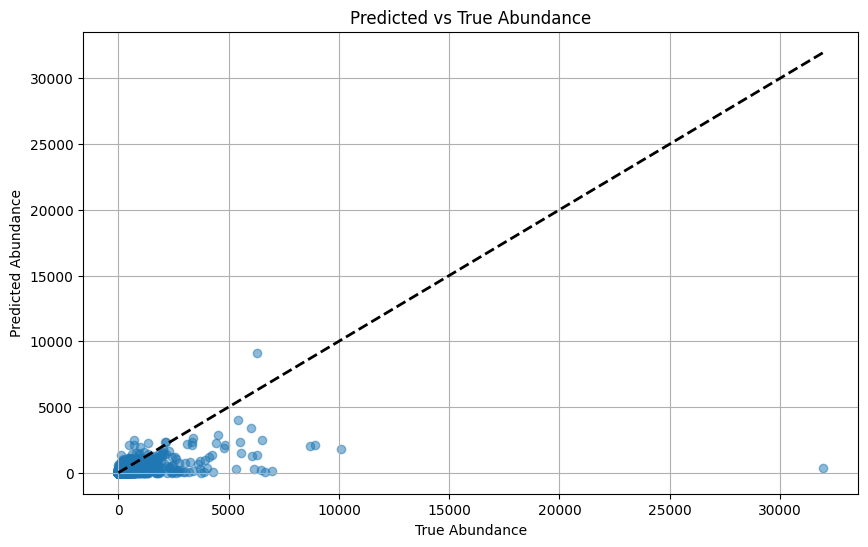

In [62]:
# plot y_pred vs y_test
plt.figure(figsize=(10, 6))
plt.scatter(y_nonlog, y_pred, alpha=0.5)
plt.plot([y_nonlog.min(), y_nonlog.max()], [y_nonlog.min(), y_nonlog.max()], 'k--', lw=2)
plt.xlabel('True Abundance')
plt.ylabel('Predicted Abundance')
plt.title('Predicted vs True Abundance')
plt.grid()
plt.show()
